In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os

<img src="https://pytorch.org/assets/images/resnet.png" alt="alt" width="50%"/>

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride !=1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(planes)
            )
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out        

In [3]:
class Resnet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super(Resnet, self).__init__()
        self.in_planes=64
        
        self.conv1 = nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,64, num_block[0], stride=1)
        self.layer2 = self._make_layer(block,128, num_block[1], stride=2)
        self.layer3 = self._make_layer(block,256, num_block[2], stride=2)
        self.layer4 = self._make_layer(block,512, num_block[3], stride=2)     
        self.linear = nn.Linear(512,num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4x4x512
        x = F.avg_pool2d(x,4) #1x1x512
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [4]:
def Resnet18():
    return Resnet(BasicBlock,[2,2,2,2])

In [5]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(trainloader)

1563

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = Resnet18()
net = net.to(device)
cudnn.benchmark=True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.0002)

def train(epoch):
    print(f'\n[Train epoch: {epoch}]')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 99:   
            print('\nCurrent batch:', str(batch_idx+1))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())
        
    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)

In [46]:
def test(epoch):
    print(f'\n[ Test epoch: {epoch} ]')
    net.eval()
    loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()
        total += targets.size(0)

        _,predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(net, './checkpoint/resnet18_cifar10_model.pt')
    torch.save(net.state_dict(), './checkpoint/resnet18_cifar10_state_dict.pt')
    torch.save({
        'model' : net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, './checkpoint/resnet18_cifar10_all.tar')
    print('Model Saved!')
    
def adjust_learning_rate(optimizer, epoch):
    lr = 0.1
    if epoch >= 100:
        lr /= 10
    if epoch >=150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr    

In [47]:
for epoch in range(0,20):
    adjust_learning_rate(optimizer,epoch)
    train(epoch)
    test(epoch)


[Train epoch: 0]

Current batch: 100
Current benign train accuracy: 0.15625
Current benign train loss: 2.2000787258148193

Current batch: 200
Current benign train accuracy: 0.21875
Current benign train loss: 2.0668959617614746

Current batch: 300
Current benign train accuracy: 0.28125
Current benign train loss: 2.303149700164795

Current batch: 400
Current benign train accuracy: 0.375
Current benign train loss: 1.9532032012939453

Current batch: 500
Current benign train accuracy: 0.34375
Current benign train loss: 1.7602101564407349

Current batch: 600
Current benign train accuracy: 0.5625
Current benign train loss: 1.6016876697540283

Current batch: 700
Current benign train accuracy: 0.3125
Current benign train loss: 1.7904541492462158

Current batch: 800
Current benign train accuracy: 0.15625
Current benign train loss: 2.0563552379608154

Current batch: 900
Current benign train accuracy: 0.40625
Current benign train loss: 1.5827394723892212

Current batch: 1000
Current benign train 

In [48]:
net = torch.load('./checkpoint/resnet18_cifar10_model.pt')
net.load_state_dict(torch.load('./checkpoint/resnet18_cifar10_state_dict.pt'))

net = net.to(device)

In [49]:
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

In [50]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [66]:
def visualize_model(net, num_images=32):
    was_training = net.training
    net.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(targets.size(0)):
                images_so_far += 1
                fig = plt.figure(figsize=(32,32))
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    net.train(mode=was_training)
                    return
        net.train(mode=was_training)

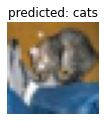

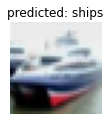

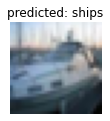

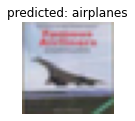

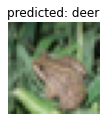

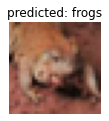

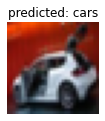

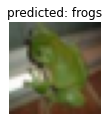

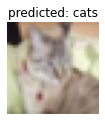

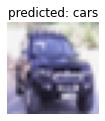

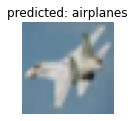

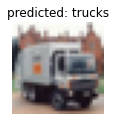

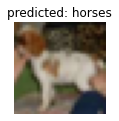

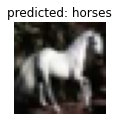

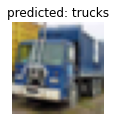

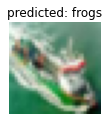

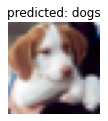

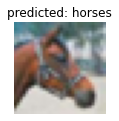

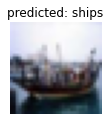

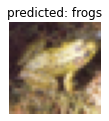

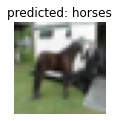

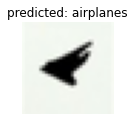

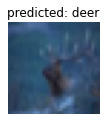

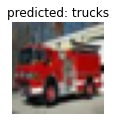

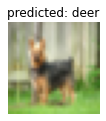

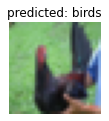

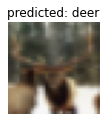

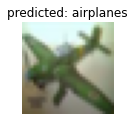

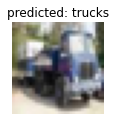

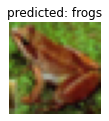

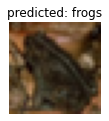

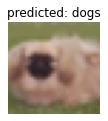

In [67]:
import matplotlib.pyplot as plt
import numpy as np
visualize_model(net, num_images=32)

In [ ]:
# 4개 빼고 다 맞춤